<a href="https://colab.research.google.com/github/RajBharti25/ILD/blob/master/ILD_model2_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/

/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir


In [7]:
#installing the required libraries to read the Dicom files
pip install pydicom

     |████████████████████████████████| 35.3MB 126kB/s 


In [0]:
#Importing Library and other utils
import pydicom as dicom
import os
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

In [0]:
PathDicom = "/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/77"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
lstFilesDCM=sorted(lstFilesDCM)
RefDs = dicom.read_file(lstFilesDCM[0])

In [0]:
#Load the excel file with the label for each disease 
label=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/clinicalParameters.csv')
label=label.iloc[:,:2]
label.head()

,id,diagnosis_category
0,3,pulmonary_fibrosis
1,7,tuberculosis
2,8,pulmonary_fibrosis
3,12,pneumocystis_pneumonia
4,13,pneumocystis_pneumonia


In [0]:
df_filt=label[label['id']==3]
df_filt.iloc[0,1]

'pulmonary_fibrosis'

In [0]:
#Creating DataFrame for keeping file dicretory and image as array into the 
number_of_image=0
for i in range(185):
  dir='/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/'+str(i)+'/'
  for dirName, subdirList, fileList in os.walk(dir):
      for filename in fileList:
          if ".dcm" in filename.lower():  # check whether the file's DICOM
              number_of_image +=1
print('Total number of input image:',number_of_image)

Total number of input image: 1641


In [0]:
start_time=time.time()
print('operation started')
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'tuberculosis',
       'sarcoidosis', 'pneumocystis_pneumonia', 'acute_interstitial_pneumonia',
       'healthy', 'eosinophilic_pneumonia',
       'desquamative_interstitial_pneumonia',
       'lymphocytic_interstitial_pneumonia'])
label_map={}
for l, x in enumerate(b):
  label_map[x]=l

image_number=0
train_label=[]
test_label=[]

#ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), number_of_image )
#Input_array=np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

for i in range(185):
  dir='/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/'+str(i)+'/'
  for dirName, subdirList, fileList in os.walk(dir):
    j=0
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            temp_dir=dir+filename
            ref=dicom.read_file(temp_dir)
            Input_array=ref.pixel_array
            max_value=np.amax(Input_array)
            Input_array=Input_array/max_value
            im=Image.fromarray(np.uint8(cm.gray(Input_array)*255))
            arr=np.array(im)
            arr=arr[:,:,0:3]
            im=Image.fromarray(arr)
            if(j==len(fileList)/2):
              im.save('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/'+str(image_number)+'.jpg')
              filt_label=label[label['id']==i]
              curr_label=filt_label.iloc[0,1]
              test_label.append([str(image_number)+'.jpg',curr_label,label_map[curr_label]])
              j+=1
              image_number +=1
            else:
             im.save('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/'+str(image_number)+'.jpg')
             filt_label=label[label['id']==i]
             curr_label=filt_label.iloc[0,1]
             train_label.append([str(image_number)+'.jpg',curr_label,label_map[curr_label]]) 
             j+=1
             image_number +=1
        if(image_number%100==0):
         print('Already processed ',image_number,' into jpg')
'''
with open("/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train_label.txt", 'w') as f:
    for s in train_label:
        f.write(str(s) + '\n')
with open("/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test_label.txt", 'w') as f:
    for s in test_label:
        f.write(str(s) + '\n')
'''

train_label1=pd.DataFrame(train_label)
test_label1=pd.DataFrame(test_label)

train_label1.to_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/train_label.csv',index=False)
test_label1.to_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv',index=False)

end_time=time.time()
print('operation_completed')
print('total time taken to complte: ',end_time-start_time,'s')

operation started
Already processed  0  into jpg
Already processed  100  into jpg
Already processed  200  into jpg
Already processed  300  into jpg
Already processed  400  into jpg
Already processed  500  into jpg
Already processed  600  into jpg
Already processed  700  into jpg
Already processed  800  into jpg
Already processed  900  into jpg
Already processed  1000  into jpg
Already processed  1100  into jpg
Already processed  1200  into jpg
Already processed  1300  into jpg
Already processed  1400  into jpg
Already processed  1400  into jpg
Already processed  1500  into jpg
Already processed  1600  into jpg
operation_completed
total time taken to complte:  460.81248927116394 s


In [0]:
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'tuberculosis',
       'sarcoidosis', 'pneumocystis_pneumonia', 'acute_interstitial_pneumonia',
       'healthy', 'eosinophilic_pneumonia',
       'desquamative_interstitial_pneumonia',
       'lymphocytic_interstitial_pneumonia'])
len(b)

10

In [0]:
'''
#To load train_label file
with open("train_label.txt", 'r') as f:
    Input_label = [line.rstrip('\n') for line in f]

To load test_label file
with open("test_label.txt", 'r') as f:
    Input_label = [line.rstrip('\n') for line in f]

'''

'\n#To load train_label file\nwith open("train_label.txt", \'r\') as f:\n    Input_label = [line.rstrip(\'\n\') for line in f]\n\nTo load test_label file\nwith open("test_label.txt", \'r\') as f:\n    Input_label = [line.rstrip(\'\n\') for line in f]\n\n'

In [0]:
# Transforming Image
image_transforms={
    #Data augmenation for training
    'train':
    transforms.Compose([
                        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                        transforms.RandomRotation(degrees=15),
                        #transforms.ColorJitter(),
                        transforms.RandomHorizontalFlip(),
                        transforms.CenterCrop(size=224), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
                        transforms.Resize(size=225),
                        transforms.CenterCrop(size=224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
} 

In [0]:
class HRCT_Dataset(Dataset):
  def __init__(self,csv_file, root_dir, transform=None):
    self.label = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return(len(self.label))
  
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label.iloc[idx, 2]
        #sample = {'image': image, 'label': label}


        if self.transform:
            #sample['image'] = self.transform(sample['image'])
            image=self.transform(image)
            
        return image,torch.tensor(label)

In [0]:
hrct_dataset_train = HRCT_Dataset(csv_file='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/train_label.csv',
                                    root_dir='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/',
                                  transform=image_transforms['train'])
hrct_dataset_test = HRCT_Dataset(csv_file='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv',
                                    root_dir='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/',
                                 transform=image_transforms['valid'])

In [0]:
len(hrct_dataset_train)

1611

In [0]:
'''
fig = plt.figure()

for i in range(len(hrct_dataset_test)):
    sample = hrct_dataset_test[i]
    
    print(i, np.array(sample['image']).shape )

    if i == 3:
      print(sample['image'])
      break
'''

"\nfig = plt.figure()\n\nfor i in range(len(hrct_dataset_test)):\n    sample = hrct_dataset_test[i]\n    \n    print(i, np.array(sample['image']).shape )\n\n    if i == 3:\n      print(sample['image'])\n      break\n"

In [0]:
a,b=hrct_dataset_test[1]

In [0]:
a.shape,b.shape

(torch.Size([3, 224, 224]), torch.Size([1, 1]))

In [0]:
for i in range(len(hrct_dataset_test)):
    features,labels = hrct_dataset_test[i]

    print(i, features.shape, labels.shape)

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([1, 1])
1 torch.Size([3, 224, 224]) torch.Size([1, 1])
2 torch.Size([3, 224, 224]) torch.Size([1, 1])
3 torch.Size([3, 224, 224]) torch.Size([1, 1])


In [0]:
# Dataloader iterators, make sure to shuffle
hrct_dataloaders = {
    'train': DataLoader(hrct_dataset_train, batch_size=16,
                        shuffle=True, num_workers=4),
    'valid': DataLoader(hrct_dataset_test, batch_size=16,
                        shuffle=True, num_workers=4)
}

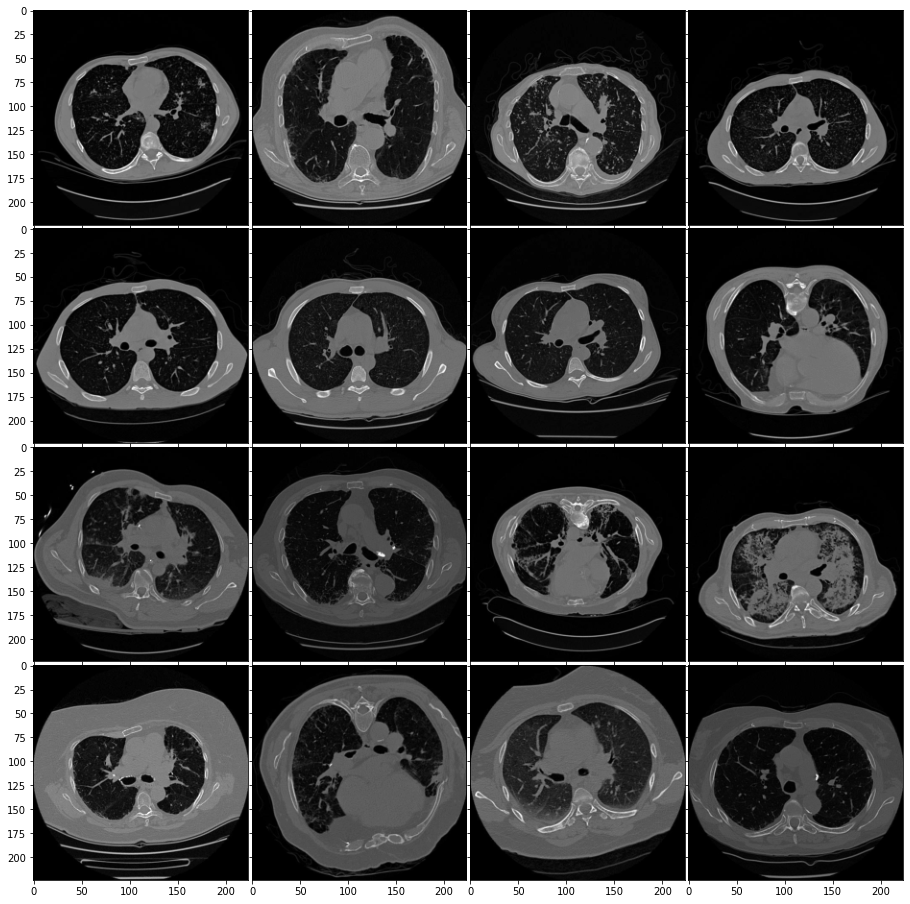

In [36]:
fig= plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
count=0

for j in range(16):
  inputs, labels = hrct_dataset_test[j]
  ax = grid[count]
  ax.imshow(inputs[1,:,:], cmap='gray')
  #ax.text(10, 210, 'Label:'.format(labels.data[j]),color='k', backgroundcolor='w', alpha=0.8)
  count += 1

In [0]:
 # Iterate through the dataloader once
trainiter = iter(hrct_dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 1]))

In [0]:
n_classes=10
batch_size=16

In [13]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
#lets check our model
inputs, labels = next(iter(hrct_dataloaders['train']))
inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.shape

torch.Size([16, 1000])

In [0]:
# Freeze model weights
for param in resnet.parameters():
    param.requires_grad = False

#adding new layers with 10 classes 
num_ftrs=resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [0]:
start_time = time.time()
model = train_model(hrct_dataloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=30)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

torch.save(model,'resnet_weight.pt')

Epoch [0/29] train loss: 0.0890 acc: 0.0000 valid loss: 0.0844 acc: 0.0000
Epoch [1/29] train loss: 0.0809 acc: 0.0000 valid loss: 0.0765 acc: 0.0000
Epoch [2/29] train loss: 0.0748 acc: 0.0000 valid loss: 0.0764 acc: 0.0000
Epoch [3/29] train loss: 0.0687 acc: 0.0000 valid loss: 0.0649 acc: 0.0000
Epoch [4/29] train loss: 0.0673 acc: 0.0000 valid loss: 0.0650 acc: 0.0000
Epoch [5/29] train loss: 0.0623 acc: 0.0000 valid loss: 0.0635 acc: 0.0000
Epoch [6/29] train loss: 0.0619 acc: 0.0000 valid loss: 0.0652 acc: 0.0000
Epoch [7/29] train loss: 0.0620 acc: 0.0000 valid loss: 0.0641 acc: 0.0000
Epoch [8/29] train loss: 0.0613 acc: 0.0000 valid loss: 0.0648 acc: 0.0000
Epoch [9/29] train loss: 0.0616 acc: 0.0000 valid loss: 0.0643 acc: 0.0000
Epoch [10/29] train loss: 0.0618 acc: 0.0000 valid loss: 0.0645 acc: 0.0000
Epoch [11/29] train loss: 0.0617 acc: 0.0000 valid loss: 0.0630 acc: 0.0000
Epoch [12/29] train loss: 0.0617 acc: 0.0000 valid loss: 0.0628 acc: 0.0000
Epoch [13/29] train lo

In [16]:
#loading the saved models parameter
# Model class must be defined somewhere
PATH='resnet_weight.pt'
model = torch.load(PATH)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Case # 2: Save model to resume training later: If you need to keep training the model that you are about to save, you need to save more than just the model. You also need to save the state of the optimizer, epochs, score, etc. You would do it like this:

```

state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    ...
}
torch.save(state, filepath)

```


To resume training you would do things like: state = torch.load(filepath), and then, to restore the state of each individual object, something like this:



```
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
```



In [0]:
 #  Save model to resume training later
 PATH='resnet_weight.pt'
 state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    ...
}
torch.save(state, filepath)

In [0]:
# Load the values for continuing the training operation
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

Lets us visualize the performence of our model

In [0]:
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'tuberculosis',
       'sarcoidosis', 'pneumocystis_pneumonia', 'acute_interstitial_pneumonia',
       'healthy', 'eosinophilic_pneumonia',
       'desquamative_interstitial_pneumonia',
       'lymphocytic_interstitial_pneumonia'])
label_map={}
label_map_inverse={}
for l, x in enumerate(b):
  label_map_inverse[l]=x
  label_map[x]=l

In [0]:
def visualize_model_output(dataloders, model, num_images=16):
  count=0
  fig= plt.figure(1, figsize=(16, 16))
  grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
  (inputs,labels) = (next(iter(dataloders['valid'])))
  inputs, labels = Variable(inputs), Variable(labels)
  outputs= model(inputs)
  _,preds = torch.max(outputs.data, 1)
  print('Predictions for the 16 validation images:',preds)
  print('Correct labels  for the 16 validation images:',labels)
  
  for j in range(inputs.size()[0]):
    ax = grid[count]
    ax.imshow( inputs.cpu().data[j,1,:,:], cmap='gray')
    ax.text(10, 210, '{}/{}'.format(label_map_inverse[preds[j].item()], label_map_inverse[labels.data[j].item()]),
            color='k', backgroundcolor='w', alpha=0.8)
    count += 1

Predictions for the 16 validation images: tensor([2, 3, 1, 0, 0, 1, 1, 0, 3, 3, 0, 1, 0, 2, 3, 2])
Correct labels  for the 16 validation images: tensor([2, 2, 1, 0, 0, 1, 0, 0, 3, 1, 3, 1, 1, 2, 3, 2])


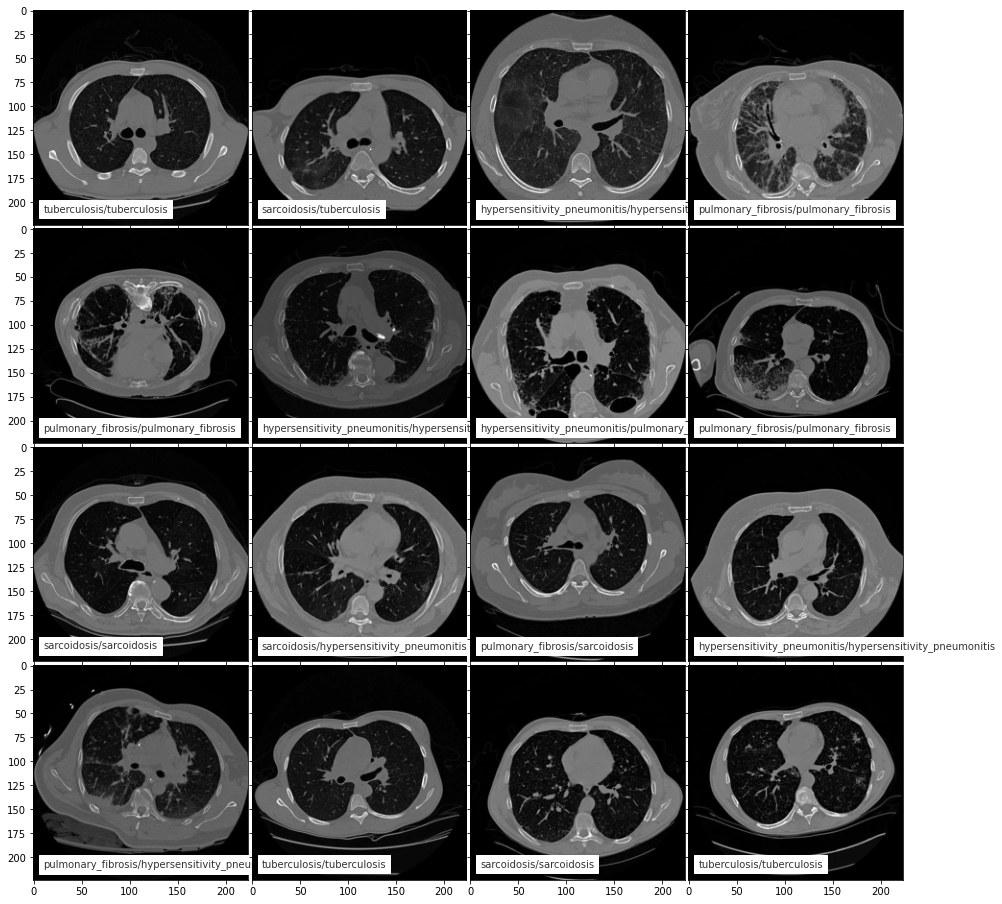

In [81]:
visualize_model_output(hrct_dataloaders, model)